# Setup

In [1]:
using DifferentialEquations, DiffEqBayes, Plots, Turing, Interpolations

# Three node network

Based on lorenz example. Writing out the system of equations individually instead of looping through each node.

In [2]:
phi(a::Number) = (exp(2*a)-1)/(exp(2*a)+1)

phi (generic function with 1 method)

In [204]:
function additive_noise!(du,u,p,t)
    s,g,W,I,σ = p
    for i = 1:length(u)
#         du[i] = 0 #no noise
        du[i] = σ #This value multiplies a random number drawn from N(0, dt)
        #i.e. noise then scales with sampling rate and effective sd of noise will be e.g. 0.1*dt
    end
end

function network_model!(du,u,p,t)
    s,g,W,I,σ = p
    for i=1:length(u)
        du[i] = -u[i] + s*phi(u[i]) + g*(sum(W[i,:].*u)) + I(t)
    end
end

network_model! (generic function with 1 method)

In [205]:
num_nodes = 3
u0 = repeat([0.0], num_nodes)
Tmax = 100.0
tspan = (0,Tmax)

s = 0.3
g = 0.7
W = [0.0 0.2 0.0; 0.4 0.0 0.0; 0.0 0.3 0.0]

ts = 1:1:Tmax
task = repeat([0.0], 100)
# task[4] = 1 #without impulse it'd be "resting state"
I = LinearInterpolation(ts, task, extrapolation_bc = 0)
dt = 0.5
σ = 0.1

p = [s,g,W,I,σ]

prob_sde = SDEProblem(network_model,additive_noise,u0,tspan,p)


SDEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: [0.0, 0.0, 0.0]

Note: If you don't turn off adaptive step size then the number of solved points will not be Tmax/dt. It will be determined as detailed [here](https://diffeq.sciml.ai/stable/basics/common_solver_opts/#Basic-Stepsize-Control)

In [206]:
sol = solve(prob_sde, dt=dt, adaptive=false)

retcode: Success
Interpolation: 1st order linear
t: 201-element Array{Float64,1}:
   0.0
   0.5
   1.0
   1.5
   2.0
   2.5
   3.0
   3.5
   4.0
   4.5
   5.0
   5.5
   6.0
   ⋮
  94.5
  95.0
  95.5
  96.0
  96.5
  97.0
  97.5
  98.0
  98.5
  99.0
  99.5
 100.0
u: 201-element Array{Array{Float64,1},1}:
 [0.0, 0.0, 0.0]
 [0.0588846021588616, -0.020476440783105673, -0.027630709408834647]
 [0.010190407036654803, 0.02627447041063278, -0.0059275339191042185]
 [0.05484285346757913, -0.07925059394471663, 0.08385114528655722]
 [0.025963123508567058, -0.06604257183765548, -0.07386361503985207]
 [0.08607981334380832, -0.06264952086273975, 0.006702428264001463]
 [-0.006049160137660111, -0.061406310821280605, 0.0791540171942125]
 [-0.08449206112361593, -0.04597259660648713, -0.0062161194635119875]
 [-0.15319867668907688, -0.020869934312920155, 0.004061905618084603]
 [-0.053178989254277116, -0.020446079428998162, 0.0785188433221778]
 [-0.016153251823393704, -0.05978293164423094, 0.16617771092562164

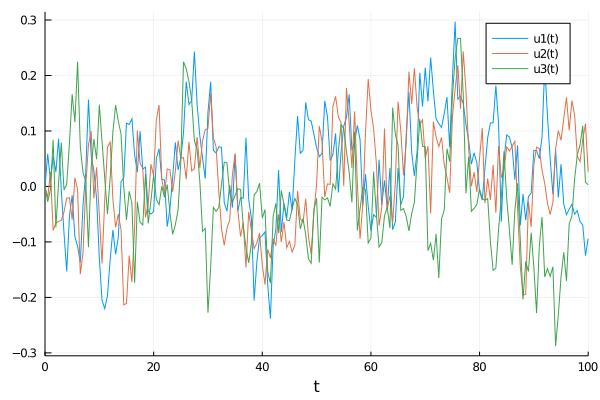

In [207]:
plot(sol)

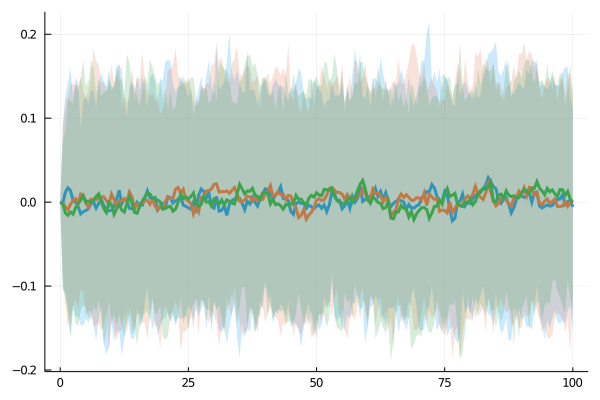

In [208]:
ensembleprob = EnsembleProblem(prob_sde)
data = solve(ensembleprob, SOSRI(), trajectories=100, dt=dt, adaptive=false)
plot(EnsembleSummary(data))

In [209]:
Turing.setadbackend(:forwarddiff)
@model function fit_nmm(data, prob)
    σ ~ LogNormal(-1,1)
    
    s = 0.3
    g = 0.7
    W = [0.0 0.2 0.0; 0.4 0.0 0.0; 0.0 0.3 0.0]
    ts = 1:1:Tmax
    task = repeat([0.0], 100)
    I = LinearInterpolation(ts, task, extrapolation_bc = 0)
    p = [s,g,W,I,σ]
    prob = remake(prob, p=p)
    predicted = solve(prob,SOSRI(),dt=dt, adaptive=false)

    if predicted.retcode != :Success
        Turing.acclogp!(_varinfo, -Inf)
    end
    for j in 1:length(data) #number of nodes
        for i = 1:length(predicted) #number of time points
            data[j][i] ~ MvNormal(predicted[i],σ)
        end
    end
end;

┌ Warning: you are using the internal variable `_varinfo`
└ @ DynamicPPL /Users/zeynepenkavi/.julia/packages/DynamicPPL/MRwtL/src/compiler.jl:181


In [210]:
model = fit_nmm(data, prob_sde)
chain = sample(model, NUTS(0.25), 5000)

LoadError: TypeError: in typeassert, expected Float64, got a value of type ForwardDiff.Dual{Nothing,Float64,1}

In [200]:
plot(chain)

Nothing